In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflo

Below is a function that returns images from duck duck go

Searching for 'pizza'


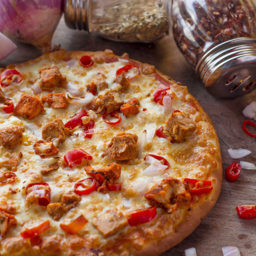

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *


def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

urls = search_images('pizza', max_images=1)
urls[0]

from fastdownload import download_url
dest = 'pizza.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


Searching for 'cartoon of mars photos'


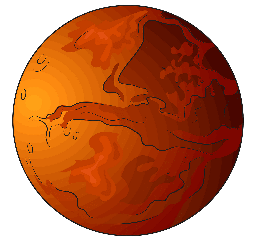

In [3]:
download_url(search_images('cartoon of mars photos', max_images=1)[0], 'mars.jpg', show_progress=False)
Image.open('mars.jpg').to_thumb(256,256)






In [4]:
searches = 'pizza','cartoon of mars'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)
    
# this next one removes failed links     
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)    




Searching for 'pizza photo'
Searching for 'cartoon of mars photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0

Now it's time to train the model with a DataLoaders- we do this with the fastai data block

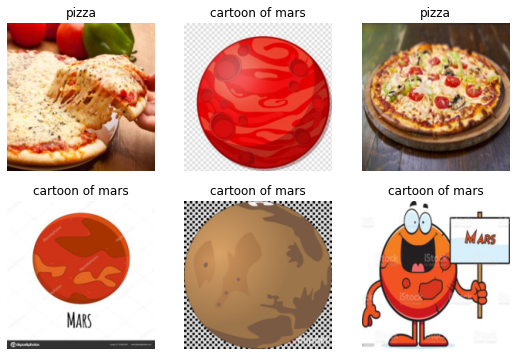

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, ##returns all our images
    splitter=RandomSplitter(valid_pct=0.2, seed=42),##randomly set aside 20 per cent fo the data for validation
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')] ##inputs have to be the same size
).dataloaders(path, bs=32) # feeds the training algorithm with a batch of images

dls.show_batch(max_n=6)

Okay now we train the model and we do this with resnet18

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate) ## we pass in the model called resnet which is normally fine for us
learn.fine_tune(3) # fine tune applies best practises

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.279786,3.557358,0.545455,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.450547,1.967151,0.545455,00:04
1,1.206142,0.106270,0.000000,00:05
2,0.825963,0.011561,0.000000,00:05


In [7]:
is_pizza,_,probs = learn.predict(PILImage.create('mars.jpg'))
print(f"This is a: {is_pizza}.")


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


This is a: cartoon of mars.
